In [3]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf


In [4]:
# Load FER dataset for extra examples
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Load model

In [7]:
pretrained_model = tf.keras.models.load_model('model_emopy_10_ep.h5')

# Show the model architecture
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 45, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 45, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 32)        1

In [8]:
labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Find and crop faces

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def cropface(input = 'example.png'):
    img_array = cv2.imread(input)
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    print("Found {0} Faces!".format(len(faces)))

    face_crop = []

    for f in faces:
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(img_array, (x,y), (x+w, y+h), (255,0,0), 3)
        # Define the region of interest in the image  
        face_crop.append(gray[y:y+h, x:x+w])
        image = face_crop[0]
        plt.imshow(image)
        return image

def imageresize(image, width = 48, height = 48):
    dim = (width, height)
    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',resized.shape)
    plt.imshow(resized)
    return resized

Found 1 Faces!
Resized Dimensions :  (48, 48)


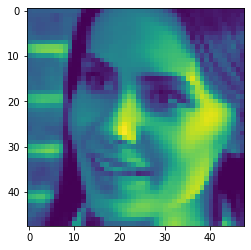

In [10]:
image = cropface(input = 'input.jpg')
inputimage = imageresize(image, width = 48, height = 48)

# Reshape image for model

(48, 48, 1)


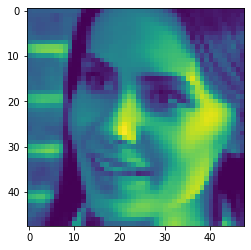

In [11]:
#reshape image for model
inputimage = np.reshape(inputimage, (48,48,1)).astype('float32')
plt.imshow(inputimage)
print(inputimage.shape)

# Convert image to tensor

In [12]:
# Convert to Tensor of type float32
image_tensor = tf.convert_to_tensor(inputimage, dtype=tf.float32)

# Add dimension to match with input mode 
image_tensor = tf.expand_dims(image_tensor, 0)


# Generate adversarial pattern for input image

In [13]:
# Generate adversarial pattern

import tensorflow as tf

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

# Get initial FER prediction for input image

In [32]:
# Get FER prediction for image
predictions = pretrained_model.predict(image_tensor)
#idx = predictions.argmax()
#print(labels[idx])
#print(idx)

In [22]:
#pred = [[0,0,0,0,0,0,0,1,0]]

# Get adversarial pattern

In [23]:
# Create adversial image
perturbations = create_adversarial_pattern(image_tensor, pred)

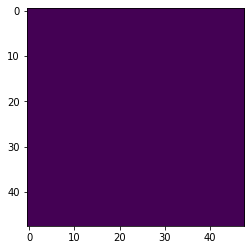

In [25]:
arr_ = np.squeeze(perturbations) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)

In [ ]:
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [20]:
def display_images(image, description):
    predictions = pretrained_model.predict(image_tensor)
    confidence = predictions.max()
    label = labels[idx]
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    #plt.title('{} \n {} : {:.2f}% Confidence'.format(label, confidence*100))
    plt.show()

# Check the effect of different epsilon values on the adversarial pattern

In [172]:
# Check the effect of different epsilon values on the adversarial pattern - lower epsilon values mean less obvious pertubation

epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x)

InvalidArgumentError: Incompatible shapes: [222,222] vs. [1,48,48,1] [Op:AddV2]